# Iomega workflow
## Calculate classical spectra similarity scores
Calculate all-vs-all similarity matrices for the data subset "Unique InchiKeys" (>12,000 spectra).

In [1]:
import os
import sys
import time

#path_data = os.path.join(os.path.dirname(os.getcwd()), 'data')
path_data = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\'
path_root = os.path.join(os.path.dirname(os.getcwd()))
sys.path.insert(0, path_root)

### Import pre-processed data subset "Unique InchiKeys"

In [2]:
from matchms.importing import load_from_json

filename = os.path.join(path_data,'gnps_positive_ionmode_unique_inchikey_cleaned_by_matchms_and_lookups.json')
spectrums = load_from_json(filename)

print("number of spectra:", len(spectrums))

number of spectra: 13717


### Post-process spectra
+ Normalize spectrum
+ Remove peaks outside m/z ratios between 0 and 1000.0
+ Discard spectra with less then 10 remaining peaks (to make it consistent with later spec2vec analysis)
+ Remove peaks with relative intensity lower than 0.01

In [3]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity

In [4]:
def post_process(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = select_by_relative_intensity(s, intensity_from=0.01, intensity_to=1.0)
    return s

# apply filters to the data
spectrums = [post_process(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums = [s for s in spectrums if s is not None]

In [5]:
print("Remaining number of spectra:", len(spectrums))

Remaining number of spectra: 12797


# Display number of peaks per spectrum

Text(0, 0.5, 'number of spectra in respective bin')

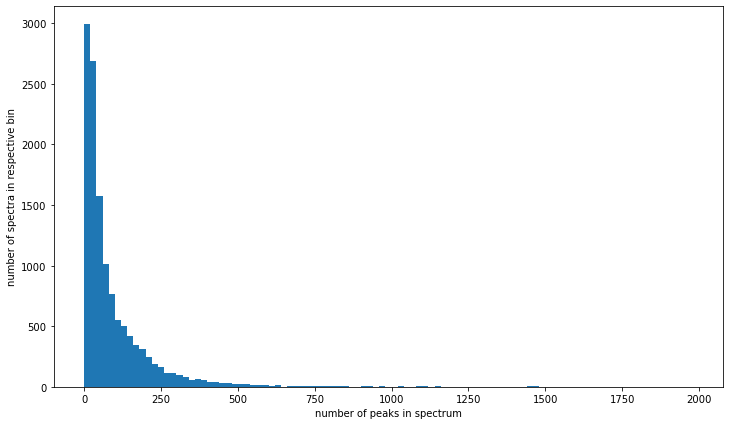

In [8]:
import numpy as np
from matplotlib import pyplot as plt

number_of_peaks = [len(spec.peaks) for spec in spectrums]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

# Calculate similarity score matrices
+ Similarities between all possible pairs of spectra will be calculated. This will give a similarity score matrix of size 12,797 x 12,797.
+ Careful: for the dataset used here, calculating the all-vs-all similarity score matrix will take a while (few hours).

## Calculate cosine similarity scores
+ here using ``tolerance = 0.005``, ``mz_power = 0.0``, ``intensity_power = 1.0``
+ ``safety_points=10`` is optional, this will simply make sure that the intermediate results are occationally saved (10x during the process).

In [8]:
import numpy as np
from matchms.similarity import CosineGreedy

# Define similarity measure
similarity_measure = CosineGreedy(tolerance=0.005, mz_power=0, intensity_power=1.0)

filename = os.path.join(path_data, "similarities_cosine_tol0005_201207.npy")

tstart = time.time()
similarity_matrix = similarity_measure.matrix(spectrums, spectrums, is_symmetric=True)
tend = time.time()

# Save results and print computation time
np.save(filename, similarity_matrix)
print(f"Calculated {similarity_matrix.shape[0]}x{similarity_matrix.shape[1]} scores in {tend-tstart} s.")
print(f"Calculated {similarity_matrix.shape[0]}x{similarity_matrix.shape[1]} scores in {(tend-tstart)/60} min.")

Calculated 12797x12797 scores in 8621.877073287964 s.
Calculated 12797x12797 scores in 143.69795122146607 min.


In [7]:
from matchms.similarity import CosineGreedy
from custom_functions.similarity_matrix import all_vs_all_similarity_matrix

# Define similarity measure
similarity_measure = CosineGreedy(tolerance=0.005)

filename = os.path.join(path_data, "similarities_cosine_tol0005_200708.npy")
similarities, num_matches = all_vs_all_similarity_matrix(spectrums, similarity_measure,
                                                         filename, safety_points=10)

 About 99.990% of similarity scores calculated.

## Compare calculation time with Spec2vec
- run on the same filtered data

In [9]:
import gensim
path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_UniqueInchikeys_ratio05_filtered_iter_50.model")

# Load pretrained model
model = gensim.models.Word2Vec.load(model_file)

In [10]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument 

In [12]:
tstart = time.time()
documents = [SpectrumDocument(s, n_decimals=2) for s in spectrums]
tend = time.time()

print(f"Time to create {len(documents)} documents: {tend-tstart} s.")

Time to create 12797 documents: 5.266417980194092 s.


In [15]:
spec2vec_similarity = Spec2Vec(model, intensity_weighting_power=0.5, allowed_missing_percentage=20.0)

tstart = time.time()
similarity_matrix = spec2vec_similarity.matrix(documents, documents, is_symmetric=True)
tend = time.time()

print(f"Calculated {similarity_matrix.shape[0]}x{similarity_matrix.shape[1]} scores in {tend-tstart} s.")
print(f"Calculated {similarity_matrix.shape[0]}x{similarity_matrix.shape[1]} scores in {(tend-tstart)/60} min.")

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.30%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.81%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.75%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.11%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.11%.
Found 6 word(s) missing in the model

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.54%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.08%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.72%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.11%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.43%.
Found 1 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.11%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.31%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.71%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.13%.
Found 5 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.68%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.13%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.21%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.11%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 2 word(s) missing in the model.

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.19%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.60%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.
Found 8 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.32%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.46%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.46%.
Found 835 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.00%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.53%.
Found 3059 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.92%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.15%.
Found 420 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.94%.
Found 56 word(s) missing in t

Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.36%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.68%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.12%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 306 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.12%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.76%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.15%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.
Found 1 word(s) missing in the m

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.41%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.15%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.54%.
Found 1 word(s) missing in the model.

Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.48%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.34%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.22%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.98%.
Found 3 word(s) missing in the model

Found 2296 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.21%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.11%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.12%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 3 word(s) missing in the mod

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.29%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.39%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.22%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 4 word(s) missing in the model.

Found 4477 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.35%.
Found 3781 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.96%.
Found 2315 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.73%.
Found 896 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.60%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.13%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.12%.
Found 3033 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.77%.
Found 1013 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.26%.
Found 2119 word(s

## Calculate cosine similarity scores (alternative parameters)
+ here using ``tolerance = 0.005``, ``mz_power = 0.0``, ``intensity_power = 0.33``
+ ``safety_points=10`` is optional, this will simply make sure that the intermediate results are occationally saved (10x during the process).

### --> Took about 8 hours

In [6]:
from matchms.similarity import CosineGreedy
from custom_functions.similarity_matrix import all_vs_all_similarity_matrix

# Define similarity measure
similarity_measure = CosineGreedy(tolerance=0.005, mz_power=0.0, intensity_power=0.33)

filename = os.path.join(path_data, "similarities_cosine_tol0005_intpow033_200716.npy")
similarities, num_matches = all_vs_all_similarity_matrix(spectrums, similarity_measure,
                                                         filename, safety_points=10)

 About 99.990% of similarity scores calculated.

## Calculate cosine similarity scores (NIST settings)
+ here using ``tolerance = 0.005``, ``mz_power = 3.0``, ``intensity_power = 0.6``
+ ``safety_points=10`` is optional, this will simply make sure that the intermediate results are occationally saved (10x during the process).

### Computation time: about 6 hours (run on: Intel i7-8550U)

In [7]:
from matchms.similarity import CosineGreedy
from custom_functions.similarity_matrix import all_vs_all_similarity_matrix

# Define similarity measure
similarity_measure = CosineGreedy(tolerance=0.005, mz_power=3.0, intensity_power=0.6)

filename = os.path.join(path_data, "similarities_cosine_tol0005_NIST_200716.npy")
similarities, num_matches = all_vs_all_similarity_matrix(spectrums, similarity_measure,
                                                         filename, safety_points=10)

 About 99.990% of similarity scores calculated.

## Calculate cosine similarity scores (MassBank settings)
+ here using ``tolerance = 0.005``, ``mz_power = 2.0``, ``intensity_power = 0.5``
+ ``safety_points=10`` is optional, this will simply make sure that the intermediate results are occationally saved (10x during the process).

### Computation time: about 6 hours (run on: Intel i7-8550U)

In [8]:
from matchms.similarity import CosineGreedy
from custom_functions.similarity_matrix import all_vs_all_similarity_matrix

# Define similarity measure
similarity_measure = CosineGreedy(tolerance=0.005, mz_power=2.0, intensity_power=0.5)

filename = os.path.join(path_data, "similarities_cosine_tol0005_MassBank_200716.npy")
similarities, num_matches = all_vs_all_similarity_matrix(spectrums, similarity_measure,
                                                         filename, safety_points=10)

 About 99.990% of similarity scores calculated.

## Calculate modified cosine similarity scores
+ here using ``tolerance = 0.005``, ``mz_power = 0.0``, ``intensity_power = 1.0``

In [13]:
from matchms.similarity import ModifiedCosine

# Define similarity measure
similarity_measure = ModifiedCosine(tolerance=0.005, mz_power=0, intensity_power=1.0)

filename = os.path.join(path_data, "similarities_mod_cosine_tol0005_201202.npy")

tstart = time.time()
similarity_matrix = similarity_measure.matrix(spectrums, spectrums, is_symmetric=True)
tend = time.time()

np.save(filename, similarity_matrix)
print(f"Calculated {similarity_matrix.shape[0]}x{similarity_matrix.shape[1]} scores in {tend-tstart} s.")

Calculated 12797x12797 scores in 8728.833800315857 s.


In [15]:
print(f"Calculated {similarity_matrix.shape[0]}x{similarity_matrix.shape[1]} scores in {(tend-tstart)/60} min.")

Calculated 12797x12797 scores in 145.48056333859762 min.


In [19]:
print(f"Matrix with {similarity_matrix.shape[0]}x{similarity_matrix.shape[1]} scores")
num_of_calculated_scores = (similarity_matrix.shape[0] ** 2 ) / 2 + similarity_matrix.shape[0]/2
print(f"Corresponding to {num_of_calculated_scores} unique scores.")
print(f"On average it took {1000 * (tend-tstart) / num_of_calculated_scores} ms per score.")

Matrix with 12797x12797 scores
Corresponding to 81888003.0 unique scores.
On average it took 0.10659478165948016 ms per score.


In [24]:
similarity_matrix[10, :25]

array([(0.0, 0), (0.0, 0), (0.11713070397508388, 2), (0.0, 0), (0.0, 0),
       (0.009961996002946179, 3), (0.0, 0), (0.15218899121648144, 5),
       (0.0, 0), (0.3158125120763052, 4), (0.9999999999999999, 87),
       (0.0, 0), (0.019468081628781737, 3), (0.0, 0), (0.0, 0), (0.0, 0),
       (0.0, 0), (0.0, 0), (0.12150674461551765, 4), (0.0, 0), (0.0, 0),
       (0.3067121187685374, 19), (0.0817813958083522, 3), (0.0, 0),
       (0.0, 0)], dtype=object)

In [28]:
a, b = zip(*similarity_matrix[:5, :5])
a

ValueError: too many values to unpack (expected 2)